# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

In [3]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [4]:
#replace the NaN values with means of the mean of the row
churnFilled = churn.fillna(churn.mean())
churnFilled

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,0.01464,0.191125,0.007038
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,0.01464,0.191125,0.007038
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,0.01464,0.191125,0.007038
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,0.01464,0.191125,0.007038
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,0.01464,0.191125,0.007038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,...,NO-CONTRACT,0,OTHER,0,27.27,COUNTRY,VIC,0.00000,1.000000,0.000000
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,...,OFF-CONTRACT,24,UNKNOWN,1,54.99,METRO,NSW,0.01464,0.191125,0.007038
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,...,ON-CONTRACT,24,APPLE,0,72.72,COUNTRY,NSW,0.00000,0.000000,0.000000


In [5]:
#drop all string values to prepare data for Linear Regression
churnCleaned = churnFilled.drop(columns=['CUST_ID', 'CFU', 'BYO_PLAN_STATUS','CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis = 1)
churnCleaned

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
INDEX,,,,,,,,,,,
1,46,1,30.0,46,54.54,15,0,24,24,1,61.40
2,60,3,55.0,59,54.54,5,0,24,24,1,54.54
3,65,1,29.0,65,40.90,15,0,12,12,1,2.50
4,31,1,51.0,31,31.81,31,0,24,24,1,6.48
5,95,1,31.0,95,54.54,0,0,24,24,1,100.22
...,...,...,...,...,...,...,...,...,...,...,...
46202,10,1,61.0,9,27.27,7,0,0,0,0,27.27
46203,2,1,53.0,2,54.54,2,0,24,24,1,54.99
46204,47,1,22.0,47,72.72,7,17,24,24,0,72.72


In [6]:
#checking the data
print(churnCleaned.head())

       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
1                  46                  1  30.0              46   
2                  60                  3  55.0              59   
3                  65                  1  29.0              65   
4                  31                  1  51.0              31   
5                  95                  1  31.0              95   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
1                54.54           15                             0   
2                54.54            5                             0   
3                40.90           15                             0   
4                31.81           31                             0   
5                54.54            0                             0   

       LAST_FX_CONTRACT_DURATION  PREV_CONTRACT_DURAT

In [7]:
#checking the shape of the data
print(churnCleaned.shape)

(46206, 11)


In [8]:
#checking for any NaN or Null values
print(churnCleaned.isnull().values.any())

False


In [9]:
#showing general statistics of the data
print(churnCleaned.describe())

       ACCOUNT_TENURE  ACCT_CNT_SERVICES           AGE  SERVICE_TENURE  \
count    46206.000000       46206.000000  46206.000000    46206.000000   
mean        45.874627           1.555707     41.411836       50.318617   
std         33.077927           0.835529     15.251168       51.925537   
min          0.000000           1.000000     -4.000000        0.000000   
25%         14.000000           1.000000     28.000000       11.000000   
50%         44.000000           1.000000     40.000000       35.000000   
75%         77.000000           2.000000     52.000000       69.000000   
max        120.000000           4.000000    116.000000      259.000000   

       PLAN_ACCESS_FEE   PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
count     46206.000000  46206.000000                  46206.000000   
mean         51.364858     10.846708                      8.237112   
std          20.855419      9.769887                      8.341476   
min           8.180000      0.000000                 

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

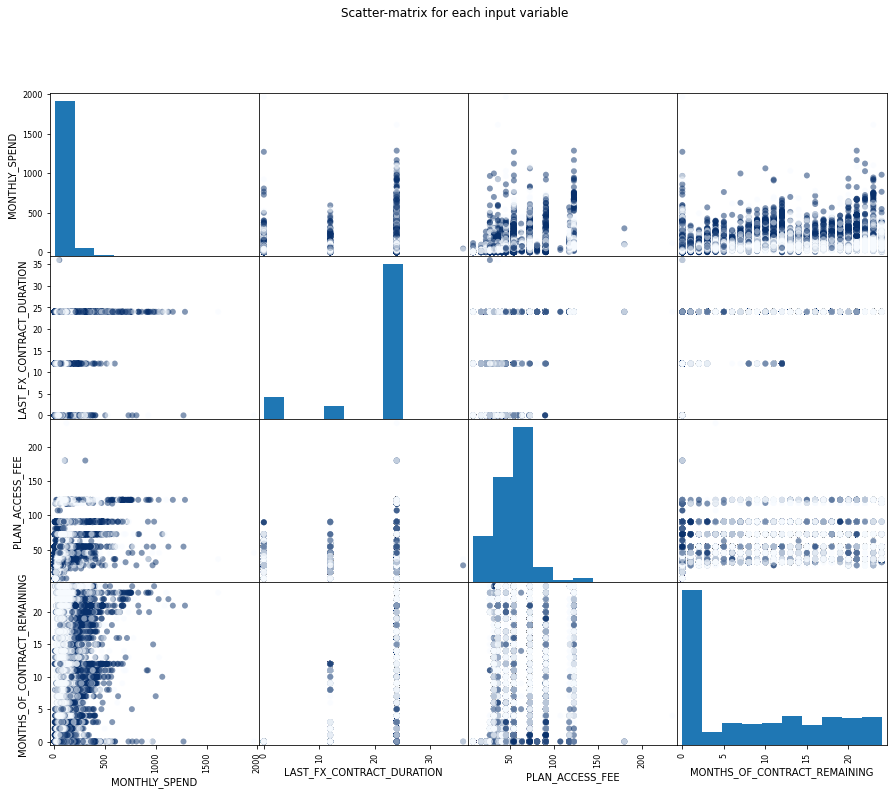

In [10]:
#explore data with scatterplot matrix to discover relationships between the data
feature_names = ['MONTHLY_SPEND', 'LAST_FX_CONTRACT_DURATION', 'PLAN_ACCESS_FEE', 'MONTHS_OF_CONTRACT_REMAINING']
X = churnCleaned[feature_names]
y = churnCleaned['CHURN_IND']
scatter = pd.plotting.scatter_matrix(X, c = y, marker = 'o', figsize=(15,12), cmap = 'Blues')
plt.suptitle('Scatter-matrix for each input variable')

A matrix scatterplot allows for a better visualisation of the data. We can see MONTHLY_SPEND and MONTHS_OF_CONTRACT_REMAINING both share similar trends in the data. MONTHS_OF_CONTRACT_REMAINING when equal to 0 spikes up. This is mainly because after a phone plan ends people tend to either get a new phone plan and change carriers due to finding a better deal.

In [11]:
#creating the training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#fitting logistic regression to the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print('Accuracy of logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.69
Accuracy of logistic regression classifier on test set: 0.70


In [13]:
#calculate the accuracy of a decision tree on the data
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.84
Accuracy of Decision Tree classifier on test set: 0.73


In [14]:
#determine the testing accuracy with KNeighbours
clf = KNeighborsClassifier(n_neighbors = 10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: ', accuracy)

Testing accuracy is:  0.736961696602467


Text(0.5, 1.0, 'K scores vs scores')

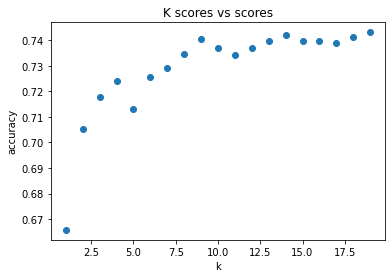

In [15]:
#plotting the k_range vs the scores to see the correlation within the testing and training set.
k_range = range (1,20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.title('K scores vs scores')

Overall, the regression analysis conducted on the Churn data was able to return a positive correlated test and training set. We are able to see, with relation to our matrix scatter plot that customers Churn mainly when their contract is ending or has ended. The k_range vs scores shows a positive correlation betweeen the test and training sets of data which included those variables shown in the matrix scatterplot above. Testing accuracy was relatively high with 73% and other tests conducted in this portfolio show similar results solidifying the accuracy of the method taken on the test and training sets of data.